In [9]:
import math
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import wandb
from google.colab import userdata  # type: ignore

In [10]:
WANDB_API_KEY = userdata.get("WANDB_API_KEY")
os.environ["WANDB_API_KEY"] = WANDB_API_KEY
wandb.login(key=WANDB_API_KEY, relogin=True)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: WARNING [wandb.login()] Changing session credentials to explicit value for https://api.wandb.ai.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [11]:
# Canonical = NEW DPO metric names
CANONICAL_METRICS = {
    "train/token_count": {
        "new": "train/token_count",
        "old": None,
    },
    "train/rewards_chosen": {
        "new": "train/rewards_chosen",
        "old": "rewards/chosen",
    },
    "train/rewards_rejected": {
        "new": "train/rewards_rejected",
        "old": "rewards/rejected",
    },
    "train/rewards_margin": {
        "new": "train/rewards_margin",
        "old": "rewards/margin",
    },
    "train/rewards_accuracy": {
        "new": "train/rewards_accuracy",
        "old": "rewards/accuracy",
    },
    "train/logps_chosen": {
        "new": "train/logps_chosen",
        "old": "logps/chosen",
    },
    "train/logps_rejected": {
        "new": "train/logps_rejected",
        "old": "logps/rejected",
    },
    "train/loss": {
        "new": "train/loss",
        "old": "train_loss",
    },
    "optim/LR": {
        "new": "optim/LR",
        "old": "learning_rate",
    },
}

STEP_CANDIDATES_NEW = ["_step", "train/global_step", "global_step", "step"]
STEP_CANDIDATES_OLD = ["training_step", "_step", "train/global_step", "global_step", "step"]


def normalize_to_canonical(df: pd.DataFrame, kind: str, smooth: float = 0.0) -> pd.DataFrame:
    """
    Returns a dataframe with:
      - step
      - ONLY new-DPO-style metric names
    """
    if df.empty:
        return df

    # Step handling (canonical)
    if "_step" not in df.columns:
        raise RuntimeError("Expected '_step' in history")
    out = pd.DataFrame({"step": pd.to_numeric(df["_step"], errors="coerce")})

    for canon_name, mapping in CANONICAL_METRICS.items():
        src = mapping[kind]
        if src and src in df.columns:
            s = pd.to_numeric(df[src], errors="coerce")
            if smooth > 0:
                s = s.ewm(alpha=smooth, adjust=False).mean()
            out[canon_name] = s

    out = out.dropna(subset=["step"]).sort_values("step")
    return out


@dataclass
class RunSpec:
    kind: str  # "new" or "old"
    path: str  # entity/project/run_id


def _ema(series: pd.Series, alpha: float) -> pd.Series:
    if alpha <= 0.0:
        return series
    return series.ewm(alpha=alpha, adjust=False).mean()

def fetch_run_history(api: wandb.Api, spec: RunSpec, keys: List[str], max_rows: int) -> pd.DataFrame:
    """
    Robust history fetch:
      1) Prefer run.history() (DataFrame)
      2) Fallback to scan_history() without keys, then filter columns locally
    """
    run = api.run(spec.path)

    # Step candidates to ensure we always bring a step axis back
    step_candidates = STEP_CANDIDATES_NEW if spec.kind == "new" else STEP_CANDIDATES_OLD

    # We'll filter to these after fetching
    wanted = set([k for k in keys if k] + step_candidates + ["_timestamp", "_runtime", "_step"])

    # ---- 1) Try run.history() (usually most reliable) ----
    try:
        h = run.history(samples=max_rows if max_rows else 1000000)  # DataFrame
        if isinstance(h, pd.DataFrame) and len(h) > 0:
            # Keep wanted columns that exist; if wanted is empty keep all
            cols = [c for c in h.columns if c in wanted] or list(h.columns)
            return h[cols].copy()
    except Exception as e:
        print(f"[warn] run.history() failed for {spec.path}: {repr(e)}")

    # ---- 2) Fallback: scan_history WITHOUT keys, then filter ----
    rows = []
    try:
        for i, row in enumerate(run.scan_history(page_size=2000)):  # no keys!
            rows.append(row)
            if max_rows and i + 1 >= max_rows:
                break
    except Exception as e:
        print(f"[warn] scan_history() failed for {spec.path}: {repr(e)}")

    if not rows:
        return pd.DataFrame()

    df = pd.DataFrame(rows)
    cols = [c for c in df.columns if c in wanted] or list(df.columns)
    return df[cols].copy()



def choose_step_column(df: pd.DataFrame, kind: str) -> Optional[str]:
    candidates = STEP_CANDIDATES_NEW if kind == "new" else STEP_CANDIDATES_OLD
    for c in candidates:
        if c in df.columns and df[c].notna().any():
            return c
    for c in df.columns:
        if "step" in c.lower() and df[c].notna().any():
            return c
    return None


def debug_df(name: str, df: pd.DataFrame, max_cols: int = 200):
    print(f"\n==== {name} ====")
    print(f"rows: {len(df)}")
    if df.empty:
        print("DataFrame is empty.")
        return
    cols = list(df.columns)
    print(f"num cols: {len(cols)}")
    # show all columns (but avoid insane spam if something is weird)
    if len(cols) <= max_cols:
        print("columns:")
        for c in cols:
            print(f"  - {c}")
    else:
        print("columns (truncated):")
        for c in cols[:max_cols]:
            print(f"  - {c}")
        print(f"  ... ({len(cols) - max_cols} more)")

    # show step-related columns and a tiny sample
    step_like = [c for c in cols if "step" in c.lower()]
    print(f"step-like columns: {step_like}")
    for c in step_like[:10]:
        s = pd.to_numeric(df[c], errors="coerce")
        non_na = int(s.notna().sum())
        print(f"  {c}: non-NaN={non_na}, min={s.min(skipna=True)}, max={s.max(skipna=True)}")
        print(f"    head: {s.dropna().head(5).tolist()}")


def normalize_metrics_force_step(df: pd.DataFrame, kind: str, smooth: float, step_col: str = "step") -> Tuple[pd.DataFrame, str]:
    """
    Force the step column to 'step'. Prints debug info if missing.
    """
    if df.empty:
        debug_df(f"{kind} raw history (EMPTY)", df)
        raise RuntimeError(f"{kind} run history is empty (no rows returned).")

    if step_col not in df.columns:
        debug_df(f"{kind} raw history (missing '{step_col}')", df)
        raise RuntimeError(f"{kind} run is missing required step column '{step_col}'.")

    out = pd.DataFrame()
    out["step"] = pd.to_numeric(df[step_col], errors="coerce")

    # Normalize each metric
    for common_name, mapping in COMMON_METRICS.items():
        raw_key = mapping.get(kind, "")
        if raw_key and raw_key in df.columns:
            out[common_name] = pd.to_numeric(df[raw_key], errors="coerce")
            if smooth > 0.0:
                out[common_name] = _ema(out[common_name], smooth)

    # Clean
    out = out.dropna(subset=["step"]).sort_values("step")

    # If after dropping NaNs we lost everything, show debug on the step column
    if out.empty:
        print(f"\nWARNING: After coercing '{step_col}' to numeric and dropping NaNs, '{kind}' normalized df is empty.")
        s = pd.to_numeric(df[step_col], errors="coerce")
        print(f"{kind} '{step_col}' non-NaN count: {int(s.notna().sum())} / {len(s)}")
        print(f"{kind} '{step_col}' head raw: {df[step_col].head(10).tolist()}")
        print(f"{kind} '{step_col}' head numeric: {s.head(10).tolist()}")
        # Also print columns so you can see what's present
        debug_df(f"{kind} raw history", df)

    return out, step_col

def align_on_step(new_df: pd.DataFrame, old_df: pd.DataFrame) -> pd.DataFrame:
    if new_df.empty or old_df.empty:
        return pd.DataFrame()

    start = max(new_df.step.min(), old_df.step.min())
    end = min(new_df.step.max(), old_df.step.max())

    new_t = new_df[(new_df.step >= start) & (new_df.step <= end)]
    old_t = old_df[(old_df.step >= start) & (old_df.step <= end)]

    merged = pd.merge(
        new_t,
        old_t,
        on="step",
        how="inner",
        suffixes=("__new", "__old"),
    )

    return merged


def plot_grid(aligned: pd.DataFrame, cols: int = 2):
    metrics = [m for m in CANONICAL_METRICS.keys()
               if f"{m}__new" in aligned.columns and f"{m}__old" in aligned.columns]

    rows = math.ceil(len(metrics) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(7.5 * cols, 3.2 * rows), squeeze=False)

    for i, m in enumerate(metrics):
        r, c = divmod(i, cols)
        ax = axes[r][c]

        ax.plot(aligned.step, aligned[f"{m}__new"], label="new", lw=1.6)
        ax.plot(aligned.step, aligned[f"{m}__old"], label="old", lw=1.6)

        ax.set_title(m)
        ax.set_xlabel("step")
        ax.grid(alpha=0.25)
        ax.legend(frameon=False)

    for j in range(len(metrics), rows * cols):
        axes[j // cols][j % cols].axis("off")

    plt.tight_layout()
    plt.show()


==== NEW raw history ====
rows: 96
num cols: 11
columns:
  - train/logps_chosen
  - train/rewards_margin
  - train/token_count
  - train/loss
  - train/logps_rejected
  - train/rewards_accuracy
  - _step
  - _timestamp
  - _runtime
  - train/rewards_chosen
  - train/rewards_rejected
step-like columns: ['_step']
  _step: non-NaN=96, min=1, max=96
    head: [1, 2, 3, 4, 5]

==== OLD raw history ====
rows: 72
num cols: 12
columns:
  - _step
  - train_loss
  - rewards/accuracy
  - _timestamp
  - logps/chosen
  - rewards/chosen
  - rewards/margin
  - learning_rate
  - training_step
  - logps/rejected
  - rewards/rejected
  - _runtime
step-like columns: ['_step', 'training_step']
  _step: non-NaN=72, min=1, max=72
    head: [1, 2, 3, 4, 5]
  training_step: non-NaN=72, min=1, max=72
    head: [1, 2, 3, 4, 5]

new_norm columns: ['step', 'train/token_count', 'train/rewards_chosen', 'train/rewards_rejected', 'train/rewards_margin', 'train/rewards_accuracy', 'train/logps_chosen', 'train/logps_re

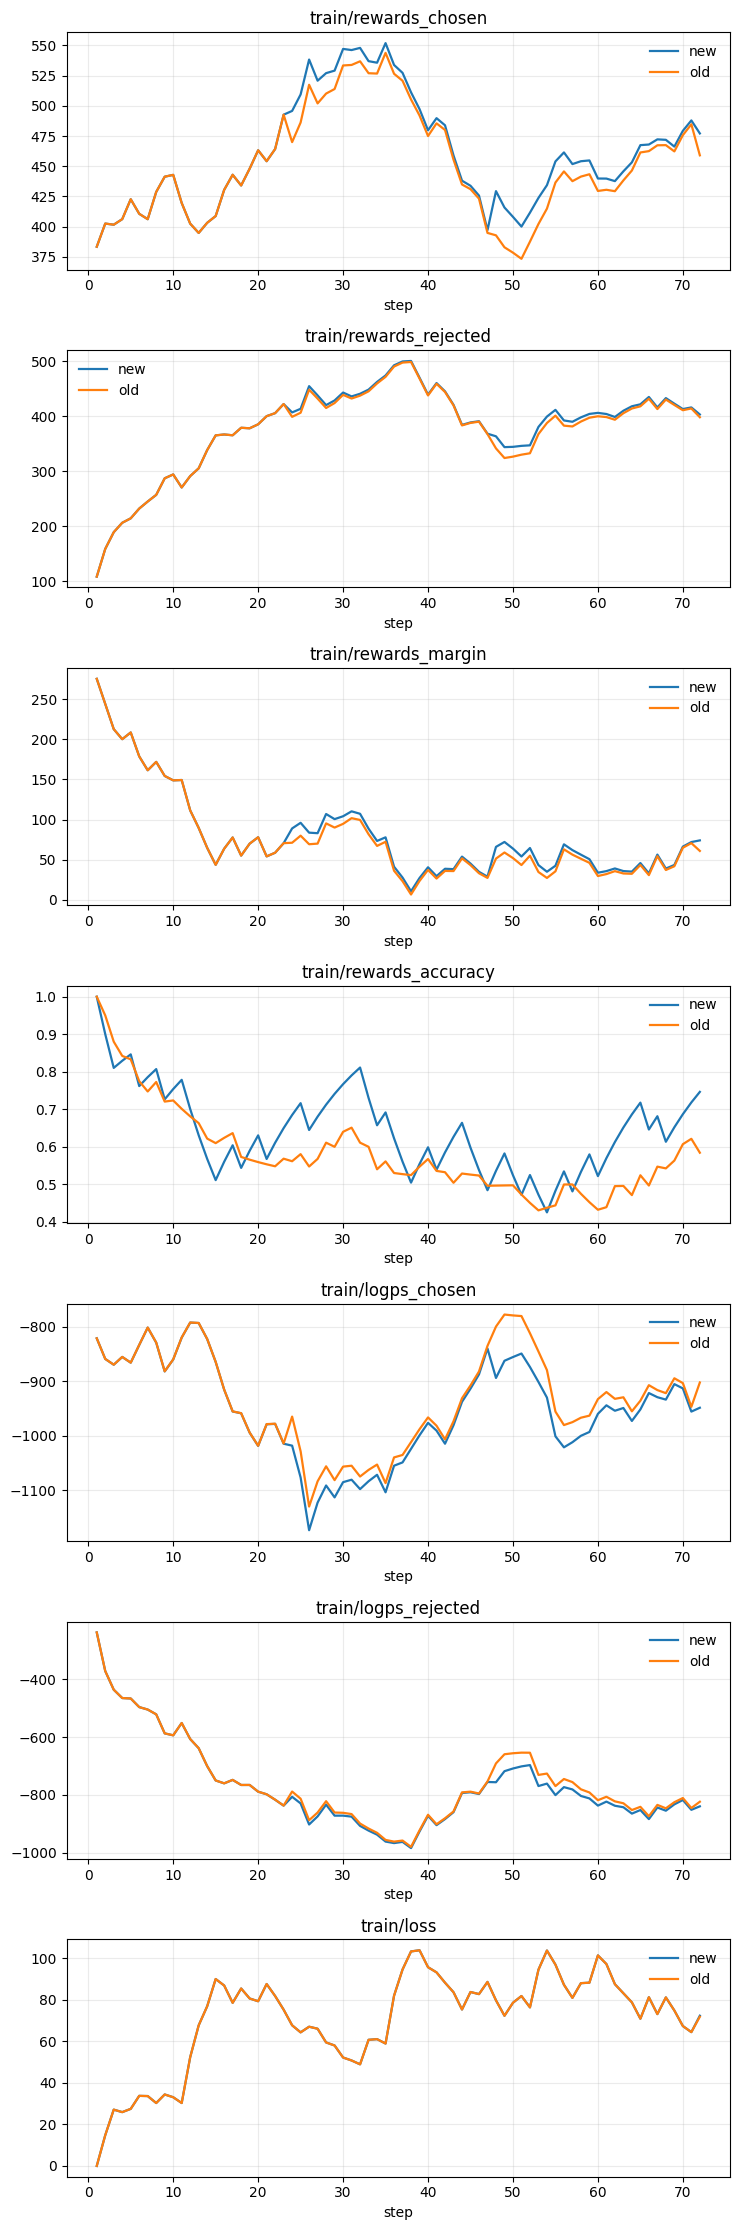

In [12]:
# --- Runs ---
# https://beaker.org/orgs/ai2/workspaces/olmo-instruct/work/01KG37GP87G75DT0SJTQTXGYQP
# https://wandb.ai/ai2-llm/open_instruct_internal/runs/en46pg9j
NEW_RUN = "ai2-llm/open_instruct_internal/2u2p47gn"
# https://beaker.org/orgs/ai2/workspaces/olmo-instruct/work/01KA62AJW9P8AWA3YKWE4Y6XZD
# https://wandb.ai/ai2-llm/open_instruct_internal/runs/p8p0vbd9
OLD_RUN = "ai2-llm/open_instruct_internal/u90xroiy"

assert "runs" not in NEW_RUN
assert "runs" not in OLD_RUN

MAX_ROWS = 20000
SMOOTH = 0.1
COLS = 1  # set 1 if you want a single column of plots; use 2 for a grid

api = wandb.Api()

# union of raw keys we might request
new_keys = [m["new"] for m in CANONICAL_METRICS.values() if m.get("new")]
old_keys = [m["old"] for m in CANONICAL_METRICS.values() if m.get("old")]
all_keys = sorted(set([k for k in new_keys + old_keys if k]))

# Fetch
new_raw = fetch_run_history(api, RunSpec(kind="new", path=NEW_RUN), all_keys, MAX_ROWS)
old_raw = fetch_run_history(api, RunSpec(kind="old", path=OLD_RUN), all_keys, MAX_ROWS)

debug_df("NEW raw history", new_raw)
debug_df("OLD raw history", old_raw)

# IMPORTANT: normalize using canonical mapping (old -> new names)
new_norm = normalize_to_canonical(new_raw, kind="new", smooth=SMOOTH)
old_norm = normalize_to_canonical(old_raw, kind="old", smooth=SMOOTH)

print("\nnew_norm columns:", list(new_norm.columns))
print("old_norm columns:", list(old_norm.columns))

# Align + truncate to overlap (inner join on step)
aligned = align_on_step(new_norm, old_norm)

print("\naligned columns:", list(aligned.columns))
print("aligned rows:", len(aligned))
plot_grid(aligned, cols=1)